In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

dataTank = pd.read_csv('data/dataBenchmark.csv')
begin = 200
end = 700

u = np.reshape(np.array(dataTank['uEst'][begin:end]), (1,-1))
y = np.reshape(np.array(dataTank['yEst'][begin:end]), (1,-1))


uVal = np.reshape(np.array(dataTank['uVal'][begin:end]), (1,-1))
yVal = np.reshape(np.array(dataTank['yVal'][begin:end]), (1,-1))

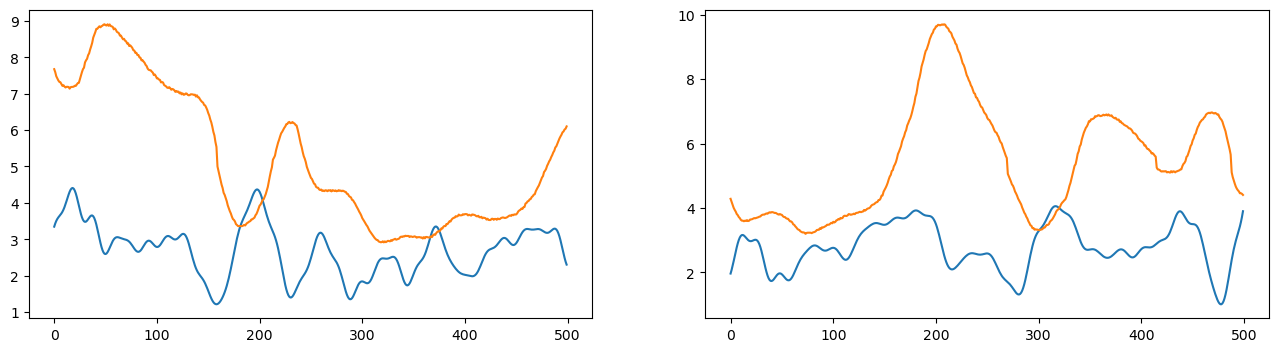

In [2]:
f, ax = plt.subplots(1, 2, figsize=[16,4])
ax[0].plot(u.T)
ax[0].plot(y.T)
plt.plot(uVal.T)
plt.plot(yVal.T)
plt.show()

In [8]:
#Selecione o tanque 
output = 0  # 0 ou 1

num = [4, 5]
params = []
Ts = 4
params.append({'nb':[2],'na':[8], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':1, 'diff':False})

#params.append({'nb':[2],'na':[4], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':1, 'diff':False})
#params.append({'nb':[3],'na':[10], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':1, 'diff':False})


sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=Ts)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.0000001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], diff=params[output]['diff'], dt=Ts)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, diff=params[output]['diff'], dt=Ts)

rs = y - slivre
rh = y - yhat

print('MAPE LIVRE:', str(round((np.mean(np.abs(rs)/np.mean(y))) * 100, 4)) + '%')
print('MAPE LIVRE:', str(round((np.mean(np.abs(rh)/np.mean(y))) * 100, 4)) + '%')

[Y1.1 U1.8 sqrtM(Y1.1)] [ 1.01206873  0.06115104 -0.10304823]
Simulação livre
--------s:  [Y1.1, Y1.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
MAPE LIVRE: 7.2006%
MAPE LIVRE: 0.53%


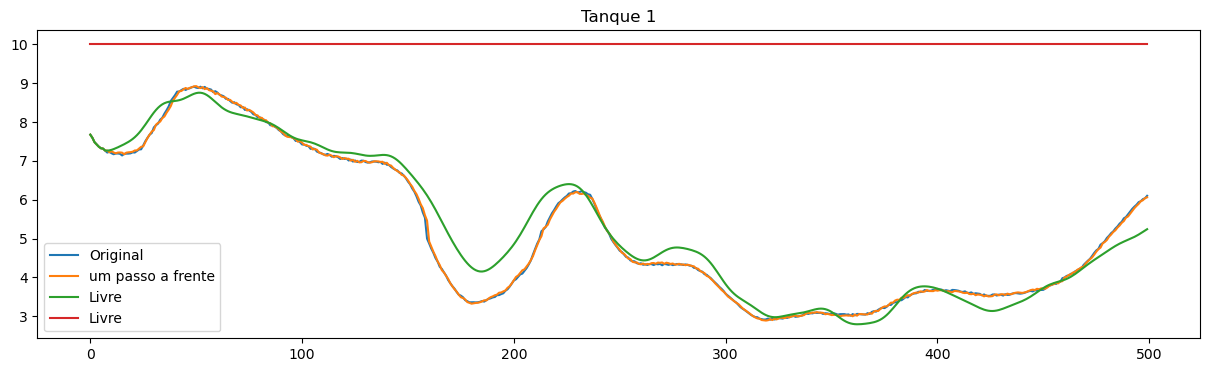

In [7]:

plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(y[output].T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.plot(np.ones(slivre.shape) * 10, label='Livre')
plt.legend()
plt.show()

## Validação

Simulação livre
--------s:  [Y1.1, Y1.2, U1.1, U1.2, U1.3, U1.4, U1.5, U1.6, U1.7, U1.8]
MAPE LIVRE: 8.7915%
MAPE LIVRE: 0.5871%


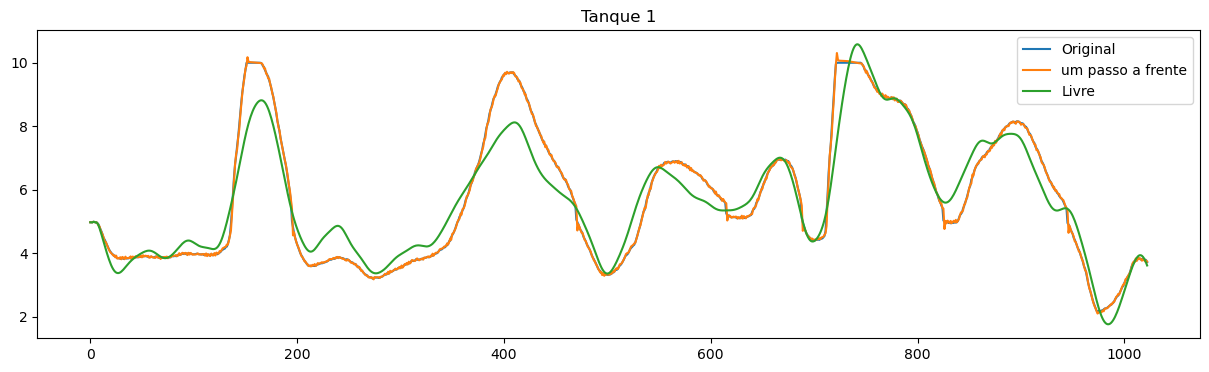

In [77]:
slivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], diff=params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, diff=params[output]['delay'], dt=0.1)

rs = yVal - slivre
rh = yVal - yhat

print('MAPE LIVRE:', str(round((np.mean(np.abs(rs)/np.mean(yVal))) * 100, 4)) + '%')
print('MAPE LIVRE:', str(round((np.mean(np.abs(rh)/np.mean(yVal))) * 100, 4)) + '%')

plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(yVal.T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.legend()
plt.show()

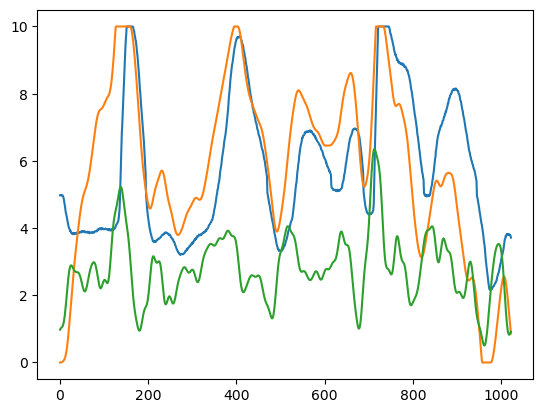

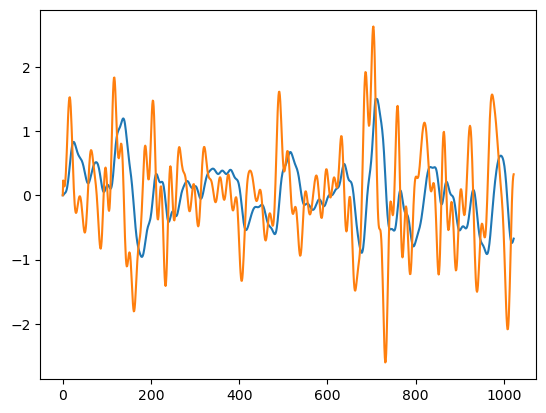

In [78]:
ww = np.zeros(uVal.shape)
dy = np.zeros(uVal.shape)
du = np.zeros(uVal.shape)

w = np.zeros(uVal.shape)
w[:, 0] = 0
dy[:, 1:] = (yVal[0, 1:] - yVal[0, :-1]) / 0.1
du[:, 1:] = (uVal[0, 1:] - uVal[0, :-1]) / 0.1


for i in range(1, uVal.shape[1]):
    w[:, i] = w[:, i-1] * 0.985 + (du[:, i-1]) * 0.05
    w[:, i] = np.clip(w[:, i], -1.1, 1.5)
    ww[:, i] =  np.clip(ww[:, i-1] + w[:, i] * 0.2, 0, 10)


plt.plot(yVal[0, :].T)
plt.plot(ww.T)
plt.plot(uVal.T)
plt.show()

plt.plot(w.T)
plt.plot(du.T)
#plt.plot((yVal[0, :] - (ww + 8)).T)
plt.show()